In [2]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp1d
from scipy.signal import medfilt
import scipy.stats as stats
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/swot/SUM03/Argo_BGC_backscatter_SO_merged'

In [4]:
siodir = '/swot/SUM02/takaya/SOCCOM/SIO'
pf = pd.read_csv(op.join(siodir,'../Fronts/pf.txt'), delim_whitespace=True, 
                 nrows=968, header=None, dtype=float, names=['lon','lat'])
saf = pd.read_csv(op.join(siodir,'../Fronts/saf.txt'), delim_whitespace=True, 
                 nrows=1079, header=None, dtype=float, names=['lon','lat'])
saccf = pd.read_csv(op.join(siodir,'../Fronts/saccf.txt'), delim_whitespace=True, 
                   nrows=995, header=None, dtype=float, names=['lon','lat'])
stf = pd.read_csv(op.join(siodir,'../Fronts/stf.txt'), delim_whitespace=True, 
                 nrows=325, header=None, dtype=float, names=['lon','lat'])
sbdy = pd.read_csv(op.join(siodir,'../Fronts/sbdy.txt'), delim_whitespace=True, 
                  nrows=501, header=None, dtype=float, names=['lon','lat'])

In [5]:
ds = xr.open_dataset(op.join(ddir,'MR690%4d_%03d.nc' % (2739,1)))
ds

<xarray.Dataset>
Dimensions:                            (N_CALIB: 1, N_HISTORY: 0, N_LEVELS: 89, N_PARAM: 5, N_PROF: 6)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                          object ...
    FORMAT_VERSION                     object ...
    HANDBOOK_VERSION                   object ...
    REFERENCE_DATE_TIME                object ...
    DATE_CREATION                      object ...
    DATE_UPDATE                        object ...
    PLATFORM_NUMBER                    (N_PROF) object ...
    PROJECT_NAME                       (N_PROF) object ...
    PI_NAME                            (N_PROF) object ...
    STATION_PARAMETERS                 (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                       (N_PROF) float64 ...
    DIRECTION                          (N_PROF) object ...
    DATA_CENTRE                        (N_PROF) object ...
    DC_REFERENCE                       (N_PROF) object ...
    

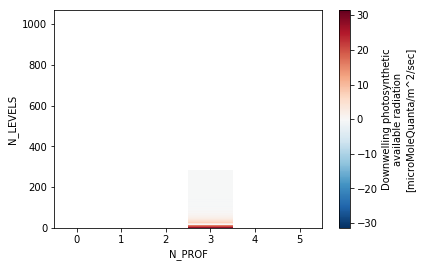

In [13]:
ds.DOWNWELLING_PAR.T.plot()

In [127]:
aB = 6.4e-6
A0,A1,A2,A3,A4,A5, = (5.80818,3.20684,4.11890,4.93845,1.01567,1.41575)
B0,B1,B2,B3 = -1e-3*np.array([7.01211,7.25958,7.93334,5.54491])
C0 = -1.32412e-7
pnew = np.append(np.arange(4,100,4),np.arange(100,1010,10))

k,l,m,q,v,w = (0,0,0,0,0,0)
for j in range(2739,2740):
    istar = 1
    for i in range(istar,300):
        fname = op.join(ddir,'MR690%4d_%03d.nc' % (j,i))
        if op.exists(fname):
            ds = xr.open_dataset(fname)
            Np, Nl = ds.PRES.shape
            lat = np.nanmean(ds.LATITUDE)
            lon = np.nanmean(ds.LONGITUDE)
            p = ds.PRES.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PRES_QC,dtype=float),
                                                                         0.),3.),4.),6.),7.), 
                                          dims=ds.PRES_QC.dims, coords=ds.PRES_QC.coords)<9.)
            p = np.ma.masked_invalid(p.where(p!=99999.).where(p>0.))
            par = ds.DOWNWELLING_PAR.where(xr.DataArray(maval(maval(maval(maval(np.asarray(ds.DOWNWELLING_PAR_QC, dtype=float),
                                                                                3.),4.),6.),7.), 
                                                        dims=ds.DOWNWELLING_PAR_QC.dims, 
                                                        coords=ds.DOWNWELLING_PAR_QC.coords)<9.)
            par = np.ma.masked_invalid(medfilt(par.where(par!=99999.).where(par>0.)[-3],5))
            ppar = p[-3]
            maskpar = par.mask
            maskppar = ppar.mask
            
            t = ds.TEMP.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.TEMP_QC,dtype=float),
                                                                         0.),3.),4.),6.),7.), 
                                          dims=ds.TEMP_QC.dims, coords=ds.TEMP_QC.coords)<9.)
            t = t.where(t!=99999.)
            s = ds.PSAL.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PSAL_QC,dtype=float),
                                                                         0.),3.),4.),6.),7.), 
                                          dims=ds.PSAL_QC.dims, coords=ds.PSAL_QC.coords)<9.)
            s = s.where(s!=99999.).where(s>0.)
            SA = xr.apply_ufunc(gsw.SA_from_SP,s,p,lon,lat)
            pt = xr.apply_ufunc(gsw.pt0_from_t,SA,t,p)
            CT = xr.apply_ufunc(gsw.CT_from_pt,SA,pt)
            n2, pN2 = gsw.Nsquared(SA.data[0],CT.data[0],p.data[0],lat=lat,axis=0)
            n2 = np.ma.masked_invalid(n2)
            rho = np.ma.masked_invalid(xr.apply_ufunc(gsw.rho,SA,CT,0)[0])
            pr = np.ma.masked_invalid(p[0])
            maskN = n2.mask
            maskr = rho.mask
            maskpr = pr.mask

            ### BBP700 ###
            pb = p[-2]
            bp700 = ds.BBP700.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.BBP700_QC,dtype=float),
                                                                              0.),3.),4.),6.),7.), 
                                                dims=ds.BBP700_QC.dims, coords=ds.BBP700_QC.coords)<9.
                                   ).where(ds.BBP700!=99999.)[-2]
            bp700 -= np.nanmedian(bp700.where(pb>=600))
            bp700 = np.ma.masked_invalid(medfilt(bp700.where(bp700>0.),5))
            chl = ds.CHLA_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.CHLA_ADJUSTED_QC,
                                                                                               dtype=float),
                                                                                    0.),3.),4.),6.),7.), 
                                                     dims=ds.CHLA_ADJUSTED_QC.dims, coords=ds.CHLA_ADJUSTED_QC.coords)<9.
                                        ).where(ds.CHLA_ADJUSTED!=99999.)[-2]
            chl -= np.nanmedian(chl.where(pb>=600))
            chl = np.ma.masked_invalid(medfilt(chl.where(chl>0.),5))
            
            maskb = bp700.mask
            maskc = chl.mask
            maskpb = pb.mask
            
            bp470 = bp700 * (470/700)**-.78
            Cphyto = 12128*bp470 + .59
            if len(np.ma.masked_array(chl,maskpb).compressed())>1 and len(np.ma.masked_array(pb,maskc).compressed())>1:
                func = pchip(np.ma.masked_array(pb,maskc).compressed(),
                             np.ma.masked_array(chl,maskpb).compressed(),extrapolate=False)
                if k == 0:
                    chl_35 = func(pnew).reshape((1,len(pnew)))
                    tnewc = np.asarray([ds.JULD[0].data.astype('datetime64')])
                    latc = np.asarray([lat])
                    lonc = np.asarray([lon])
                    k += 1
                else:
                    chl_35 = np.append(chl_35, func(pnew).reshape((1,len(pnew))), axis=0)
                    tnewc = np.append(tnewc, ds.JULD[0].data.astype('datetime64'))
                    latc = np.append(latc, lat)
                    lonc = np.append(lonc, lon)
            if len(np.ma.masked_array(Cphyto,maskpb).compressed())>1 and len(np.ma.masked_array(pb,maskb).compressed())>1:
                funC = pchip(np.ma.masked_array(pb,maskb).compressed(),
                             np.ma.masked_array(Cphyto,maskpb).compressed(),extrapolate=False)
                funB = pchip(np.ma.masked_array(pb,maskb).compressed(),
                             np.ma.masked_array(bp700,maskpb).compressed(),extrapolate=False)
                if l == 0:
                    C_35 = funC(pnew).reshape((1,len(pnew)))
                    bp_35 = funB(pnew).reshape((1,len(pnew)))
                    tnewb = np.asarray([ds.JULD[0].data.astype('datetime64')])
                    latb = np.asarray([lat])
                    lonb = np.asarray([lon])
                    l += 1
                else:
                    C_35 = np.append(C_35, funC(pnew).reshape((1,len(pnew))), axis=0)
                    bp_35 = np.append(bp_35, funB(pnew).reshape((1,len(pnew))), axis=0)
                    tnewb = np.append(tnewb, ds.JULD[-1].data.astype('datetime64'))
                    latb = np.append(latb, lat)
                    lonb = np.append(lonb, lon)
            if len(np.ma.masked_array(rho,maskpr).compressed())>1 and len(np.ma.masked_array(pr,maskr).compressed())>1:
                for u in range(len(ds.N_LEVELS)):
                    if ~np.isnan(rho[u]):
                        top = u
                        break
                if pr[top]<=1e1:
                    itop = np.abs(pr-10).argmin()
                    pMLD = pr[itop+np.nanargmin(np.abs((rho[itop:]-rho[itop])-0.03))]
                else:
                    pMLD = np.nan
                func = pchip(np.ma.masked_array(pr,maskr).compressed(),
                             np.ma.masked_array(rho,maskpr).compressed(),extrapolate=False)
                if m == 0:
                    rho_35 = func(pnew).reshape((1,len(pnew)))
                    pMLD_35 = np.asarray([pMLD])
                    tnewr = np.asarray([ds.JULD[-1].data.astype('datetime64')])
                    latr = np.asarray([lat])
                    lonr = np.asarray([lon])
                    m += 1
                else:
                    rho_35 = np.append(rho_35, func(pnew).reshape((1,len(pnew))), axis=0)
                    pMLD_35 = np.append(pMLD_35, np.asarray([pMLD]))
                    tnewr = np.append(tnewr, ds.JULD[0].data.astype('datetime64'))
                    latr = np.append(latr, lat)
                    lonr = np.append(lonr, lon)
            if len(np.ma.masked_array(n2,maskN).compressed())>1:
                func = pchip(np.ma.masked_array(pN2,maskN).compressed(),
                             np.ma.masked_array(n2,maskN).compressed(),extrapolate=False)
                if v == 0:
                    N2_35 = func(pnew).reshape((1,len(pnew)))
                    v += 1
                else:
                    N2_35 = np.append(N2_35, func(pnew).reshape((1,len(pnew))), axis=0)
            if len(np.ma.masked_array(par,maskppar).compressed())>1 and len(np.ma.masked_array(ppar,maskpar).compressed())>1:
                func = pchip(np.ma.masked_array(ppar,maskpar).compressed(),
                             np.ma.masked_array(par,maskppar).compressed(),extrapolate=False)
                if q == 0:
                    par_35 = func(pnew).reshape((1,len(pnew)))
                    tnewp = np.asarray([ds.JULD[-2].data.astype('datetime64')])
                    latp = np.asarray([lat])
                    lonp = np.asarray([lon])
                    q += 1
                else:
                    par_35 = np.append(par_35, func(pnew).reshape((1,len(pnew))), axis=0)
                    tnewp = np.append(tnewp, ds.JULD[-2].data.astype('datetime64'))
                    latp = np.append(latp, lat)
                    lonp = np.append(lonp, lon)
                    
            mlt = np.nanmean(pt.where(p<=pMLD)[0])
            PB = 1.3e-3 * 1.065**(mlt-20)
            #############################################
            # Phytoplankton division rate
            mu = chl/Cphyto * PB * (1.-np.exp(-aB*par/PB))
            #############################################
            pp = np.ma.masked_invalid(mu*Cphyto)
            maskpp = pp.mask
            mu = np.ma.masked_array(mu,maskpp)
            if len(np.ma.masked_array(pp,maskppar).compressed())>1 and all(np.diff(np.ma.masked_array(ppar,maskpp).compressed())>0.):
                funP = pchip(np.ma.masked_array(ppar,maskpp).compressed(),
                            np.ma.masked_array(pp,maskppar).compressed(),extrapolate=False)
                funM = pchip(np.ma.masked_array(ppar,maskpp).compressed(),
                            np.ma.masked_array(mu,maskppar).compressed(),extrapolate=False)
                PPtp = funP(pnew).reshape((1,len(pnew)))
                Mutp = funM(pnew).reshape((1,len(pnew)))
                if w == 0:
                    PP = PPtp
                    Mu = Mutp
                    tnewpp = np.asarray([ds.JULD[-2].data.astype('datetime64')])
                    latpp = np.asarray([lat])
                    lonpp = np.asarray([lon])
                    w += 1
                else:
                    PP = np.append(PP, PPtp, axis=0)
                    Mu = np.append(Mu, Mutp, axis=0)
                    tnewpp = np.append(tnewpp, ds.JULD[-2].data.astype('datetime64'))
                    latpp = np.append(latpp, lat)
                    lonpp = np.append(lonpp, lon)
            
                            
chl_35 = xr.DataArray(chl_35, dims=['time','pres'],
                     coords={'time':tnewc,'pres':pnew,'lat':('time',latc),'lon':('time',lonc)}
                     ).dropna('time',how='all')
C_35 = xr.DataArray(C_35, dims=['time','pres'], 
                   coords={'time':tnewb,'pres':pnew,'lat':('time',latb),'lon':('time',lonb)}
                   ).dropna('time',how='all')
bp_35 = xr.DataArray(bp_35, dims=['time','pres'], 
                    coords={'time':tnewb,'pres':pnew,'lat':('time',latb),'lon':('time',lonb)}
                    ).dropna('time',how='all')
rho_35 = xr.DataArray(rho_35, dims=['time','pres'],
                     coords={'time':tnewr,'pres':pnew,'lat':('time',latr),'lon':('time',lonr)}
                     ).dropna('time',how='all')
N2_35 = xr.DataArray(N2_35, dims=['time','pres'],
                     coords={'time':tnewr,'pres':pnew,'lat':('time',latr),'lon':('time',lonr)}
                     ).dropna('time',how='all')
par_35 = xr.DataArray(par_35, dims=['time','pres'],
                     coords={'time':tnewp,'pres':pnew,'lat':('time',latp),'lon':('time',lonp)}
                     ).dropna('time',how='all')
pMLD_35 = xr.DataArray(pMLD_35, dims=['time'], 
                      coords={'time':tnewr,'lat':('time',latr),'lon':('time',lonr)}
                      ).dropna('time',how='all')
PPxr = xr.DataArray(PP, dims=['time','pres'],
                   coords={'time':tnewpp,'pres':pnew,'lat':('time',latpp),'lon':('time',lonpp)}
                   ).dropna('time',how='all')
Muxr = xr.DataArray(Mu, dims=['time','pres'],
                   coords={'time':tnewpp,'pres':pnew,'lat':('time',latpp),'lon':('time',lonpp)}
                   ).dropna('time',how='all')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in less_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ip

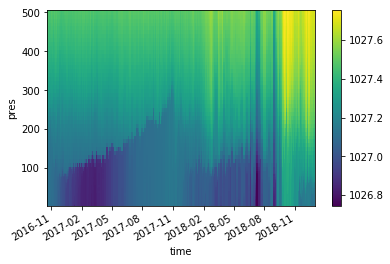

In [15]:
rho_35.T.plot()

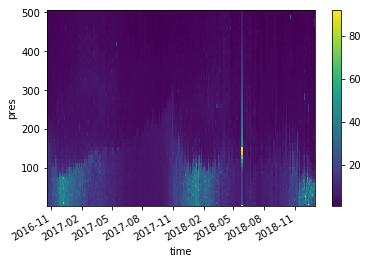

In [16]:
C_35.T.plot()

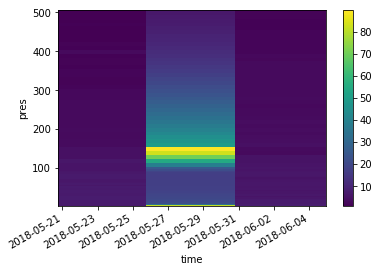

In [19]:
C_35.sel(time=slice('2018-05-22','2018-06-05')).T.plot()

In [21]:
C_35.sel(time='2018-05-28T06:50:00')

<xarray.DataArray (time: 1, pres: 65)>
array([[81.429841, 33.516756, 21.547081, 20.921235, 20.357114, 19.851547,
        19.401362, 19.003389, 18.654457, 18.351395, 18.09103 , 17.870194,
        17.685713, 17.534417, 17.413135, 17.318696, 17.247929, 17.197662,
        17.164725, 17.145946, 17.138155, 17.34873 , 18.84792 , 21.627424,
        25.49965 , 38.729804, 54.6859  , 70.436818, 83.051435, 89.59863 ,
        49.616795, 47.101783, 44.682502, 42.357096, 40.123708, 37.980479,
        35.925552, 33.95707 , 32.073175, 30.27201 , 28.551717, 26.91044 ,
        25.346319, 23.857499, 22.442121, 21.098328, 19.824263, 18.618067,
        17.477885, 16.401857, 15.388127, 14.434838, 13.540131, 12.702149,
        11.919035, 11.188932, 10.509981,  9.880326,  9.298109,  8.761472,
         8.268558,  7.81751 ,  7.40647 ,  7.03358 ,  6.696984]])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-28T06:50:00
  * pres     (pres) int64 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 ...
    lat  

In [128]:
C_35.sel(time='2018-05-28T06:50:00')[:] = np.nan
bp_35.sel(time='2018-05-28T06:50:00')[:] = np.nan

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.data is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.data is deprecated and will be removed in a future version
  app.launch_new_instance()


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


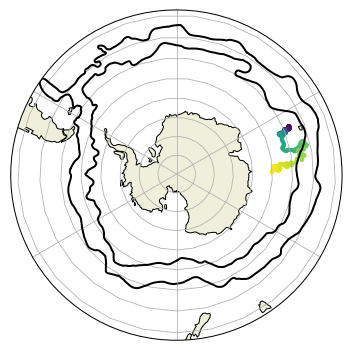

In [39]:
fig = plt.figure(figsize=(5,7))
fig.set_tight_layout(True)
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
im = ax.scatter(C_35.lon.values, C_35.lat.values, 
               s=10., c=C_35.time.values, rasterized=True,
               transform=ccrs.PlateCarree())
ax.plot(pf.lon.data, (pf.lat-1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.plot(saf.lon.data, (saf.lat+1.).data, 'k', lw=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

# plt.savefig(op.join(ddir,'../SOCCOM_4180_trajectory.pdf'))

In [129]:
par1 = par_35.where(par_35*1e-6*86400>=0.1) 
pEu_35 = par_35[:,0].copy()
pEu_35[:] = np.nan
for i in range(len(pEu_35)):
    if len(np.ma.masked_invalid(par1[i]).compressed())>0.:
        pEu_35[i] = pnew[len(np.ma.masked_invalid(par1[i]).compressed())]
pEu_35

<xarray.DataArray (time: 283)>
array([ 92., 110.,  44., ...,  76.,  92.,  52.])
Coordinates:
  * time     (time) datetime64[ns] 2016-10-20T11:39:59.999999744 ...
    pres     int64 4
    lat      (time) float64 -52.43 -52.4 -52.4 -52.38 -52.36 -52.35 -52.32 ...
    lon      (time) float64 66.99 66.95 66.96 66.95 66.99 67.02 67.05 67.05 ...

In [130]:
dt_intp = rho_35.time.diff('time')
dt_intp = int(np.asarray(dt_intp.where(dt_intp>np.timedelta64(0)).min(),dtype=float)/(86400*1e9))
if dt_intp == 0:
    dt_intp = 1
print(dt_intp)

tnew = np.arange(np.asarray(rho_35.time,dtype='datetime64[D]')[0]+np.timedelta64(12,'h'), 
                np.asarray(rho_35.time,dtype='datetime64[D]')[-1]+np.timedelta64(24,'h'), 
                np.timedelta64(dt_intp,'D'),
                dtype='datetime64')
chl_intp = chl_35.interp(time=tnew, method='linear')
C_intp = C_35.interp(time=tnew, method='linear')
rho_intp = rho_35.interp(time=tnew, method='linear')
N2_intp = N2_35.interp(time=tnew, method='linear')
bp_intp = bp_35.interp(time=tnew, method='linear')
par_intp = par_35.interp(time=tnew, method='linear')
pML_intp = pMLD_35.interp(time=tnew, method='linear')
pEu_intp = pEu_35.interp(time=tnew, method='linear')
Mu_intp = Muxr.interp(time=tnew, method='linear')
PP_intp = PPxr.interp(time=tnew, method='linear')
C_intp

1


<xarray.DataArray (time: 802, pres: 115)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [15.671181, 15.802062, 15.89951 , ...,       nan,       nan,       nan],
       [16.105832, 15.223871, 14.56017 , ...,       nan,       nan,       nan],
       ...,
       [25.024855, 21.072147, 21.186443, ...,       nan,       nan,       nan],
       [23.533815, 23.166702, 22.825487, ...,       nan,       nan,       nan],
       [22.042776, 25.261257, 24.464531, ...,       nan,       nan,       nan]])
Coordinates:
  * pres     (pres) int64 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 ...
    lat      (time) float64 nan -52.43 -52.4 -52.39 -52.38 -52.36 -52.34 ...
    lon      (time) float64 nan 66.99 66.95 66.96 66.96 66.99 67.03 67.05 ...
  * time     (time) datetime64[ns] 2016-10-19T12:00:00 2016-10-20T12:00:00 ...

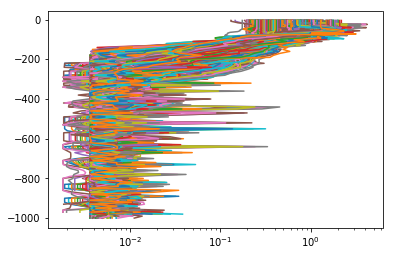

In [131]:
fig, ax = plt.subplots()
for i in range(len(chl_intp.time)):
    ax.plot(chl_intp[i],-pnew)
ax.set_xscale('log')

In [133]:
dt = C_35.time.diff('time')
dt = dt.where(dt>np.timedelta64(30,'D'))
dts = np.empty(0, dtype='datetime64')
for i in range(len(dt)):
    if dt.data[i].astype(np.timedelta64) != np.timedelta64('NaT'):
        dts = np.append(dts, np.asarray([dt.time.data[i-1], dt.time.data[i]], dtype='datetime64'))
if len(dts)>0:
    if len(dts)==2:
        C_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        chl_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        bp_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        rho_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        pML_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
    elif len(dts)==4:
        C_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        C_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        chl_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        chl_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        bp_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        bp_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        rho_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        rho_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        pML_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        pML_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
    elif len(dts)==6:
        C_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        C_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        C_intp.sel(time=slice(dts[4],dts[5]))[:] = np.nan
        chl_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        chl_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        chl_intp.sel(time=slice(dts[4],dts[5]))[:] = np.nan
        bp_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        bp_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        bp_intp.sel(time=slice(dts[4],dts[5]))[:] = np.nan
        rho_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        rho_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        rho_intp.sel(time=slice(dts[4],dts[5]))[:] = np.nan
        pML_intp.sel(time=slice(dts[0],dts[1]))[:] = np.nan
        pML_intp.sel(time=slice(dts[2],dts[3]))[:] = np.nan
        pML_intp.sel(time=slice(dts[4],dts[5]))[:] = np.nan
    else:
        C_intp[:] = np.nan
        chl_intp[:] = np.nan
        bp_intp[:] = np.nan
        rho_intp[:] = np.nan
        pML_intp[:] = np.nan
C_intp

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: In the future, NAT != NAT will be True rather than False.
  """


<xarray.DataArray (time: 802, pres: 115)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [15.671181, 15.802062, 15.89951 , ...,       nan,       nan,       nan],
       [16.105832, 15.223871, 14.56017 , ...,       nan,       nan,       nan],
       ...,
       [25.024855, 21.072147, 21.186443, ...,       nan,       nan,       nan],
       [23.533815, 23.166702, 22.825487, ...,       nan,       nan,       nan],
       [22.042776, 25.261257, 24.464531, ...,       nan,       nan,       nan]])
Coordinates:
  * pres     (pres) int64 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 ...
    lat      (time) float64 nan -52.43 -52.4 -52.39 -52.38 -52.36 -52.34 ...
    lon      (time) float64 nan 66.99 66.95 66.96 66.96 66.99 67.03 67.05 ...
  * time     (time) datetime64[ns] 2016-10-19T12:00:00 2016-10-20T12:00:00 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


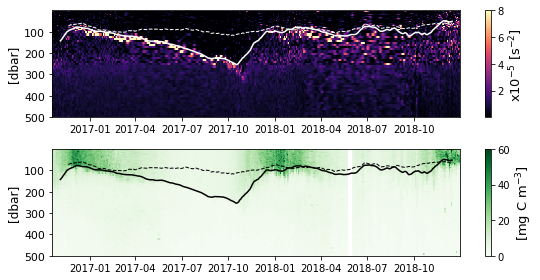

In [134]:
import matplotlib as mpl

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,4))
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(N2_intp.time, -pnew, 1e5*N2_intp.data.T, cmap='magma',
                    vmin=1e-2, vmax=8e0, rasterized=True
                    )
im2 = ax2.pcolormesh(C_intp.time, -pnew, C_intp.where(C_intp<1e2).data.T,
                     vmin=0., vmax=60, cmap='Greens', rasterized=True)

ax1.plot(pML_intp.time, -pML_intp.rolling(time=31, center=True).mean(), 'w')
ax2.plot(pML_intp.time, -pML_intp.rolling(time=31, center=True).mean(), 'k')
ax1.plot(pEu_intp.time, -pEu_intp.rolling(time=31, center=True).mean(), 'w--', lw=1)
ax2.plot(pEu_intp.time, -pEu_intp.rolling(time=31, center=True).mean(), 'k--', lw=1)

ax1.set_ylim([-500,0])
ax2.set_ylim([-500,0])

ax1.set_yticks([-100,-200,-300,-400,-500])
ax2.set_yticks([-100,-200,-300,-400,-500])

ax1.set_yticklabels([100,200,300,400,500], fontsize=11)
ax2.set_yticklabels([100,200,300,400,500], fontsize=11)

ax1.set_ylabel(r"[dbar]", fontsize=12)
ax2.set_ylabel(r"[dbar]", fontsize=12)

cb1 = fig.colorbar(im1, ax=ax1)
cb2 = fig.colorbar(im2, ax=ax2)
cb1.set_label(r"x10$^{-5}$ [s$^{-2}$]", fontsize=13)
cb2.set_label(r"[mg C m$^{-3}$]", fontsize=13)

# plt.savefig(op.join(ddir,'../Argo_Analysis/SOCLIM_2739_N2-C.pdf'))

In [135]:
dp = np.diff(pnew)[:24]
dp = np.append(dp, 7)
dp = np.append(dp, np.diff(pnew[24:]))

In [136]:
CintgH = C_35[:,0].copy()
CintgH[:] = np.nan
# Cintg = Cml.copy()
# CintgH = Cml.copy()
j, i = (0,0)
for tt in C_35.time.data:
    if ~np.isnan(C_35[i]).all() and tt in chl_35.time.data:
        CintgH[i] = np.nansum(C_35.where(C_35<1e2).sel(time=tt).where(chl_35.sel(time=tt)>.02)*dp)
#     if tt in pMLD_35.time.data:
#         Cml[i] = np.nansum(C_35.where(C_35<1e2)[i].where(C_35.pres<=pMLD_35.sel(time=tt))*dp)/pMLD_35.sel(time=tt)
#         if tt in pEu_35.time.data:
#             if np.isnan(pEu_35.sel(time=tt).data):
#                 pEu_stk = 1e2
#             else:
#                 pEu_stk = pEu_35.sel(time=tt).data
#         else:
#             pEu_stk = 1e2
#         if pMLD_35.sel(time=tt).data > pEu_stk:
#             Cintg[i] = np.nansum(C_35.where(C_35<1e2).where(C_35.pres<=pMLD_35.sel(time=tt)).sel(time=tt)*dp)
#         else:
#             Cintg[i] = np.nansum(C_35.where(C_35<1e2).where(C_35.pres<=pEu_stk).sel(time=tt)*dp)
    i += 1
    
CintgH

<xarray.DataArray (time: 285)>
array([2656.476813, 2462.712486, 2342.049111, ..., 2807.000049, 2729.953813,
       3101.47213 ])
Coordinates:
  * time     (time) datetime64[ns] 2016-10-20T11:39:59.999999744 ...
    pres     int64 4
    lat      (time) float64 -52.43 -52.4 -52.4 -52.38 -52.36 -52.35 -52.32 ...
    lon      (time) float64 66.99 66.95 66.96 66.95 66.99 67.02 67.05 67.05 ...

In [107]:
PPintgH = PPxr[:,0].copy()
PPintgH[:] = np.nan

j, i = (0,0)
for tt in PPxr.time.data:
    if ~np.isnan(PPxr[i]).all():
        PPintgH[i] = np.nansum(PPxr.sel(time=tt)*dp)
    i += 1
    
PPintgH

<xarray.DataArray (time: 282)>
array([0.006275, 0.005837, 0.000471, ..., 0.009497, 0.008825, 0.00274 ])
Coordinates:
  * time     (time) datetime64[ns] 2016-10-20T11:39:59.999999744 ...
    pres     int64 4
    lat      (time) float64 -52.43 -52.4 -52.4 -52.38 -52.36 -52.35 -52.32 ...
    lon      (time) float64 66.99 66.95 66.96 66.95 66.99 67.02 67.05 67.05 ...

In [108]:
muP = PPintgH/CintgH
muP

<xarray.DataArray (time: 282)>
array([1.917364e-06, 1.923118e-06, 1.527230e-07, ..., 2.787795e-06,
       2.755925e-06, 7.846841e-07])
Coordinates:
  * time     (time) datetime64[ns] 2016-10-20T11:39:59.999999744 ...
    pres     int64 4
    lat      (time) float64 -52.43 -52.4 -52.4 -52.38 -52.36 -52.35 -52.32 ...
    lon      (time) float64 66.99 66.95 66.96 66.95 66.99 67.02 67.05 67.05 ...

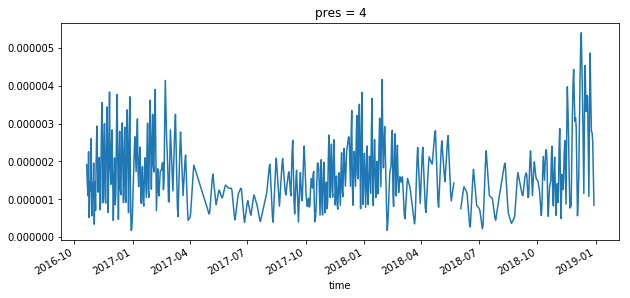

In [109]:
muP_tp = muP.interp(time=tnew, method='linear')
muP_tp.where(muP_tp>0.).plot(figsize=(10,4))

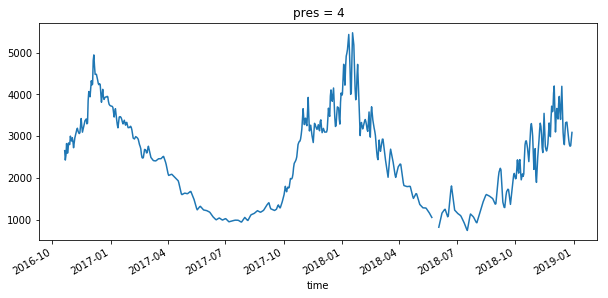

In [137]:
CintgH_tp = CintgH.interp(time=tnew, method='linear')
# Cintg_tp = Cintg.interp(time=tnew, method='linear')
# Cml_intp = Cml.interp(time=tnew, method='linear')
CintgH_tp.where(CintgH_tp>0.).plot(figsize=(10,4))

31 20


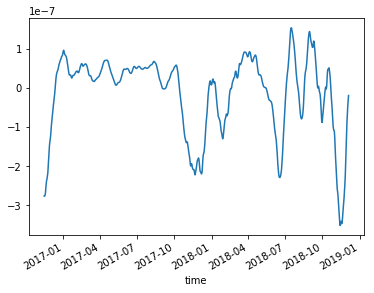

In [84]:
nroll = int(30/dt_intp)
if nroll % 2 == 0:
    nroll += 1
deltaT = dt_intp*86400
nroll20 = int(20/dt_intp)
if nroll20 % 2 != 0:
    nroll20 += 1
print(nroll,nroll20)

dHdt = (-pML_intp.rolling(time=nroll, center=True).mean() 
        + pML_intp.rolling(time=nroll, center=True).mean().shift(time=-nroll20)
       )[:-nroll20]/(deltaT*nroll20)
rD = pML_intp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dHdt.data
                                                                     center=True).mean().time.diff('time').data))})
rD.plot()

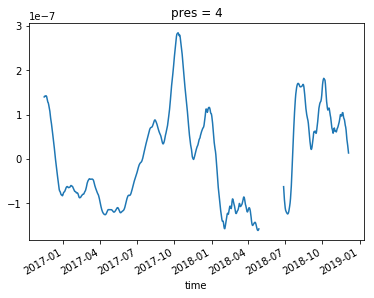

In [138]:
dCintgHdt = (-CintgH_tp.where(CintgH_tp<1.5e4).rolling(time=nroll, center=True).mean()
             + CintgH_tp.where(CintgH_tp<1.5e4).rolling(time=nroll, center=True).mean().shift(time=-nroll20)
            )[:-nroll20]/(deltaT*nroll20)

rPH = CintgH_tp.rolling(time=nroll, center=True).mean()[int(.5*nroll20):-int(.5*nroll20)]**-1 * dCintgHdt.data
rPH.plot()

In [139]:
rPH_pos = rPH.where(rPH>0.)
rD_pos = rD.where(rD>0.)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


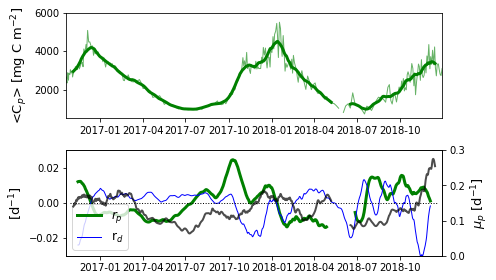

In [141]:
fig, (ax1,ax3) = plt.subplots(nrows=2, ncols=1, figsize=(7,4))
fig.set_tight_layout(True)
ax4 = ax3.twinx()

ax1.plot(CintgH.time, CintgH.where(CintgH<1e4).where(CintgH>5e2).data, 'g', lw=1, alpha=.6)
ax1.plot(CintgH_tp.rolling(time=nroll, center=True).mean().time, 
         CintgH_tp.where(CintgH_tp<1e4).where(CintgH_tp>5e2).rolling(time=nroll, center=True).mean().data, 
         'g', lw=3, label=r'<C$_{p}$>$_H$')
ax3.plot(rPH.time.data, (rPH*86400).where(np.abs(rPH*86400)<0.06), 'g', lw=3, label=r'$r_p$')
ax4.plot(muP_tp.rolling(time=nroll, center=True).mean().time, 
         muP_tp.rolling(time=nroll, center=True).mean().data*86400, 
         'k', lw=2, alpha=.7)
ax3.plot(rD.time.data, rD*86400, c='b', label=r'r$_d$', lw=1)
ax3.plot(rPH.time, np.zeros(len(rPH.time)), 'k:', lw=1)

ax4.spines["right"].set_edgecolor('k')
ax4.tick_params(axis='y', colors='k')
ax1.set_xlim([C_35.time.data[0],C_35.time.data[-1]])
ax3.set_xlim([C_35.time.data[0],C_35.time.data[-1]])
ax1.set_ylim([500,6000])
ax3.set_ylim([-.03,.03])
ax4.set_ylim([0,.3])

ax1.set_ylabel(r"<C$_{p}$> [mg C m$^{-2}$]", fontsize=13)
ax3.set_ylabel(r"[d$^{-1}$]", fontsize=13)
ax4.set_ylabel(r"$\mu_p$ [d$^{-1}$]", fontsize=13)
ax3.legend(loc='lower left', fontsize=12)
# plt.savefig(op.join(ddir,'../Argo_Analysis/SOCLIM_2739_C-r.pdf'))